# Ordered MNIST (jax)

_Authors_: [Pietro Novelli](https://pietronvll.github.io/) and [Giacomo Turri](https://github.com/g-turri)

This example closely follows the experiment from _"Learning invariant representations of time-homogeneous stochastic dynamical systems"_ <cite data-footcite="Kostic2023DPNets">(Kostic et al. 2024)</cite>, implemented using **JAX**.

## Setup

We begin by loading the Ordered MNIST dataset from `kooplearn` and visualizing a small sample.

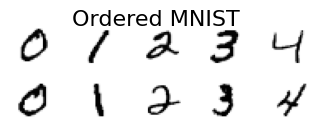

In [1]:
import matplotlib.pyplot as plt

from kooplearn.datasets import fetch_ordered_mnist

# We only use the digits 0 to 4
num_digits = 5
images, labels = fetch_ordered_mnist(num_digits=num_digits)
# Plot the data
fig, axs = plt.subplots(nrows=2, ncols=num_digits, figsize=(0.8*num_digits, 1.3))
for img, ax in zip(images, axs.ravel()):
    ax.imshow(img, cmap="Greys")
    ax.axis("off")
fig.suptitle("Ordered MNIST", fontsize=16)
plt.show()

We split the dataset into training, validation, and test sets, using 3,000 points for training, 1,000 for validation, and 1,000 for testing.

In [2]:
import numpy as np

# train images will be images[train_ids] and so on
train_ids, val_ids, test_ids = np.split(np.arange(5000), [3000, 4000])

## Training the Oracle

Each evolution operator model will be validated as follows: starting from a test image of digit $c$, we predict the next image using `model.predict`. The prediction should resemble an MNIST-style image of digit $c+1$ (modulo `configs.classes`).  

We then feed this predicted image to a pretrained MNIST classifier (the _oracle_) and evaluate how its accuracy changes over successive predictions.  

We begin by defining the _oracle_ classifier.

In [3]:
from functools import partial

import jax
import jax.numpy as jnp
from flax import nnx


class CNNEncoder(nnx.Module):
    def __init__(self, num_classes: int, rngs: nnx.Rngs):
        # NHWC convention
        self.conv1 = nnx.Conv(1, 16, kernel_size=(5, 5), padding=2, rngs=rngs)
        self.conv2 = nnx.Conv(16, 32, kernel_size=(5, 5), padding=2, rngs=rngs)
        self.max_pool = partial(nnx.max_pool, window_shape=(2, 2), strides=(2, 2))
        self.lin_out = nnx.Linear(32 * 7 * 7, num_classes, rngs=rngs)

    def __call__(self, X):
        if X.ndim == 3:
            X = jnp.expand_dims(X, -1)
        X = self.max_pool(nnx.relu(self.conv1(X)))
        X = self.max_pool(nnx.relu(self.conv2(X)))
        X = X.reshape(X.shape[0], -1)  # Flatten
        out = self.lin_out(X)
        return out


class CNNDecoder(nnx.Module):
    def __init__(self, num_classes: int, rngs: nnx.Rngs):
        self.lin_proj = nnx.Linear(num_classes, 32 * 7 * 7, rngs=rngs)
        self.conv1 = nnx.ConvTranspose(32, 16, kernel_size=(5, 5), padding=2, rngs=rngs)
        self.conv2 = nnx.ConvTranspose(16, 1, kernel_size=(5, 5), padding=2, rngs=rngs)

    def upsample(self, X, scale_factor: int = 2):
        N, H, W, C = X.shape
        X_upsampled = jax.image.resize(
            X, (N, H * scale_factor, W * scale_factor, C), method="bilinear"
        )
        return X_upsampled

    def __call__(self, X):
        X = self.lin_proj(X)
        X = X.reshape(X.shape[0], 7, 7, 32)
        X = self.conv1(nnx.relu(self.upsample(X)))
        X = self.conv2(nnx.relu(self.upsample(X)))
        # Remove last dim
        X = jnp.squeeze(X)
        return X


def make_dataloader(*arrays, batch_size, shuffle=False):
    """
    Minimal data loader function that iterates over batches of NumPy arrays.

    Args:
        *arrays: A variable number of NumPy arrays. All arrays must have
                 the same size in the first dimension.
        batch_size (int): The size of each batch.
        shuffle (bool): Whether to shuffle the data before iterating.

    Yields:
        A tuple of batched arrays.
    """
    if not arrays:
        return

    # Get the total number of samples from the first array
    num_samples = arrays[0].shape[0]

    # Validate that all arrays have the same first dimension
    for arr in arrays[1:]:
        if arr.shape[0] != num_samples:
            raise ValueError(
                "All arrays must have the same size in the first dimension."
            )

    # Create an array of indices
    indices = np.arange(num_samples)

    # Shuffle indices if requested
    if shuffle:
        # Use NumPy's random generator for shuffling CPU-side indices
        rng = np.random.default_rng()
        rng.shuffle(indices)

    # Yield batches
    for start_idx in range(0, num_samples, batch_size):
        end_idx = min(start_idx + batch_size, num_samples)
        batch_indices = indices[start_idx:end_idx]

        # Yield a tuple of slices from each array
        yield tuple(arr[batch_indices] for arr in arrays)

 Now we train the oracle classifier.

In [4]:
import optax


def train_oracle_classifier():
    num_epochs = 20
    # Prepare data
    X_train = images[train_ids]
    labels_train = labels[train_ids]
    X_val = images[val_ids]
    labels_val = labels[val_ids]
    # Define model and optimizer
    rngs = nnx.Rngs(0)
    oracle = CNNEncoder(num_classes=num_digits, rngs=rngs)
    nnx.display(oracle)

    optimizer = nnx.Optimizer(oracle, optax.adamw(8e-4, weight_decay=0.01), wrt=nnx.Param)
    metrics = nnx.MultiMetric(
        accuracy=nnx.metrics.Accuracy(),
        loss=nnx.metrics.Average("loss"),
    )

    def loss_fn(model: CNNEncoder, batch):
        images, labels = batch
        logits = model(images)
        loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=labels
        ).mean()
        return loss, logits

    @nnx.jit
    def train_step(
        model: CNNEncoder, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch
    ):
        """Train for a single step."""
        _, labels = batch
        grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
        (loss, logits), grads = grad_fn(model, batch)
        metrics.update(loss=loss, logits=logits, labels=labels)  # In-place updates.
        optimizer.update(model, grads)  # In-place updates.

    @nnx.jit
    def eval_step(model: CNNEncoder, metrics: nnx.MultiMetric, batch):
        _, labels = batch
        loss, logits = loss_fn(model, batch)
        metrics.update(loss=loss, logits=logits, labels=labels)  # In-place updates.

    for epoch in range(num_epochs):
        train_dl = make_dataloader(X_train, labels_train, batch_size=64, shuffle=True)
        val_dl = make_dataloader(
            X_val, labels_val, batch_size=len(X_val), shuffle=False
        )
        oracle.train()
        for batch in train_dl:
            train_step(oracle, optimizer, metrics, batch)
        if (epoch + 1) % 5 == 0 or (epoch == 0):
            print(f"EPOCH {epoch + 1:>2}  ", end="")
            for metric, value in metrics.compute().items():
                print(f"train/{metric} {value:.3f} ", end="")
        metrics.reset()
        oracle.eval()
        for batch in val_dl:
            eval_step(oracle, metrics, batch)
        if (epoch + 1) % 5 == 0 or (epoch == 0):
            for metric, value in metrics.compute().items():
                print(f"eval/{metric} {value:.3f} ", end="")
            print("")
        metrics.reset()
    return oracle

oracle = train_oracle_classifier()

EPOCH  1  train/accuracy 0.855 train/loss 0.556 eval/accuracy 0.954 eval/loss 0.145 
EPOCH  5  train/accuracy 0.983 train/loss 0.054 eval/accuracy 0.979 eval/loss 0.078 
EPOCH 10  train/accuracy 0.996 train/loss 0.021 eval/accuracy 0.983 eval/loss 0.039 
EPOCH 15  train/accuracy 1.000 train/loss 0.006 eval/accuracy 0.985 eval/loss 0.031 
EPOCH 20  train/accuracy 1.000 train/loss 0.003 eval/accuracy 0.987 eval/loss 0.030 


## Evolution Operator Models

Next, we will train multiple evolution operator models that predict the next image given the current one. Each model will be stored in `trained_models` for later evaluation.

In [5]:
# Global variable collecting the trained models
trained_models = {}

#### Linear model

As a baseline evolution operator, we fit a simple linear `Ridge` model (equivalent to *Principal Component Regression*) on the flattened pixel features using `kooplearn`'s [FeatureFlattener](../generated/kooplearn.preprocessing.FeatureFlattener.rst).

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from kooplearn.linear_model import Ridge
from kooplearn.preprocessing import FeatureFlattener

# Data preparation
flattener = FeatureFlattener()
scaler = StandardScaler()
data_pipe = Pipeline([("flattener", flattener), ("scaler", scaler)])
data_pipe.fit(images[train_ids])

linear_model = Ridge(n_components=num_digits, eigen_solver="dense")
linear_model.fit(data_pipe.transform(images[train_ids]))
trained_models["Linear"] = {"model": linear_model, "embedder": data_pipe}

### Classifier features (as in Sec. 6 of <cite data-footcite="Kostic2022">Kostic et al. 2022</cite>)

Here, we use the oracle classifier to extract feature embeddings and fit a ``Ridge`` model on these classifier features. This is possible using the convenient ``kooplearn``'s [FeatureMapEmbedder](../generated/kooplearn.torch.FeatureMapEmbedder.rst).

In [7]:
from kooplearn.jax.utils import NnxFeatureMapEmbedder

embedder = NnxFeatureMapEmbedder(encoder=oracle)
images_embedded = embedder.transform(images[train_ids])
classifier_model = Ridge(n_components=num_digits).fit(
    images_embedded, y=images[train_ids]
)
trained_models["Classifier_Baseline"] = {
    "model": classifier_model,
    "embedder": embedder,
}

### Encoder-only methods

We train encoder-only models using the [SpectralContrastiveLoss](../generated/kooplearn.torch.nn.SpectralContrastiveLoss.rst) and [VampLoss](../generated/kooplearn.torch.nn.VampLoss.rst) objectives to learn latent spaces in which a linear evolution operator can operate effectively.

In [8]:
from typing import Callable


class FeatureMap(nnx.Module):
    def __init__(self, num_digits: int, rngs: nnx.Rngs, normalize_latents: bool = True):
        super().__init__()
        self.normalize_latents = normalize_latents
        self.backbone = CNNEncoder(num_classes=num_digits, rngs=rngs)
        self.lin = nnx.Linear(num_digits, num_digits, use_bias=False, rngs=rngs)

    def __call__(self, X, lagged: bool = False):
        z = self.backbone(X)
        if self.normalize_latents:
            norm = jnp.linalg.vector_norm(z, axis=-1, keepdims=True).clip(min=1e-12)
            z = z / norm
        if lagged:
            z = self.lin(z)
        return z


def train_encoder_only(criterion: Callable):
    num_epochs = 50
    X_train = images[train_ids]
    X_val = images[val_ids]
    # Initialize model, loss and optimizer
    rngs = nnx.Rngs(0)
    model = FeatureMap(num_digits, rngs=rngs)
    optimizer = nnx.Optimizer(model, optax.adamw(2e-3, weight_decay=0.01), wrt=nnx.Param)
    metrics = nnx.MultiMetric(
        loss=nnx.metrics.Average("loss"),
    )

    def loss_fn(model: FeatureMap, batch):
        x, x_lag = batch
        phi, phi_lag = model(x), model(x_lag, lagged=True)
        loss = criterion(phi, phi_lag)
        return loss

    @nnx.jit
    def train_step(
        model: FeatureMap, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch
    ):
        """Train for a single step."""
        grad_fn = nnx.value_and_grad(loss_fn)
        loss, grads = grad_fn(model, batch)
        metrics.update(loss=loss)  # In-place updates.
        optimizer.update(model, grads)  # In-place updates.

    @nnx.jit
    def eval_step(model: FeatureMap, metrics: nnx.MultiMetric, batch):
        loss = loss_fn(model, batch)
        metrics.update(loss=loss)  # In-place updates.

    for epoch in range(num_epochs):
        train_dl = make_dataloader(
            X_train[:-1], X_train[1:], batch_size=64, shuffle=True
        )
        val_dl = make_dataloader(
            X_val[:-1], X_val[1:], batch_size=len(X_val), shuffle=False
        )
        model.train()
        for batch in train_dl:
            train_step(model, optimizer, metrics, batch)
        if (epoch + 1) % 5 == 0 or (epoch == 0):
            print(f"EPOCH {epoch + 1:>2}  ", end="")
            for metric, value in metrics.compute().items():
                print(f"train/{metric} {value:.2f} ", end="")
        metrics.reset()
        model.eval()
        for batch in val_dl:
            eval_step(model, metrics, batch)
        if (epoch + 1) % 5 == 0 or (epoch == 0):
            for metric, value in metrics.compute().items():
                print(f"eval/{metric} {value:.2f} ", end="")
            print("")
        metrics.reset()

    embedder = NnxFeatureMapEmbedder(encoder=model)
    evolution_operator_model = Ridge(n_components=num_digits).fit(
        embedder.transform(X_train), X_train
    )

    return {
        "model": evolution_operator_model,
        "embedder": embedder,
    }

In [ ]:
from kooplearn.jax.nn import spectral_contrastive_loss, vamp_loss

_vamp_loss = partial(vamp_loss, center_covariances=False)
for name, criterion in zip(["VAMPNets", "Spectral Contrastive Loss"],
                           [ _vamp_loss, spectral_contrastive_loss]):
    print(f"Fitting {name}")
    trained_models[name] = train_encoder_only(criterion)

Fitting VAMPNets
EPOCH  1  train/loss -3.82 eval/loss -4.30 
EPOCH  5  train/loss -4.80 eval/loss -4.56 
EPOCH 10  train/loss -4.93 eval/loss -4.62 
EPOCH 15  train/loss -4.96 eval/loss -4.65 
EPOCH 20  train/loss -4.97 eval/loss -4.68 
EPOCH 25  train/loss -4.98 eval/loss -4.70 
EPOCH 30  train/loss -4.98 eval/loss -4.71 
EPOCH 35  train/loss -4.99 eval/loss -4.71 
EPOCH 40  train/loss -4.98 eval/loss -4.71 
EPOCH 45  train/loss -4.99 eval/loss -4.72 
EPOCH 50  train/loss -4.99 eval/loss -4.71 
Fitting Spectral Contrastive Loss
EPOCH  1  train/loss -0.96 eval/loss -1.00 
EPOCH  5  train/loss -1.76 eval/loss -1.94 
EPOCH 10  train/loss -3.03 eval/loss -3.04 
EPOCH 15  train/loss -3.57 eval/loss -3.51 
EPOCH 20  train/loss -4.38 eval/loss -4.20 
EPOCH 25  train/loss -4.74 eval/loss -4.53 
EPOCH 30  train/loss -4.88 eval/loss -4.59 
EPOCH 35  train/loss -4.96 eval/loss -4.65 
EPOCH 40  train/loss -4.94 eval/loss -4.67 
EPOCH 45  train/loss -5.01 eval/loss -4.67 
EPOCH 50  train/loss -4.9

### Dynamical Autoencoder <cite data-footcite="Lusch2018">(Lusch et al., 2018)</cite>

To complement the encoder-only methods, we also train a **dynamical autoencoder** that jointly learns an encoder, a decoder, and a linear evolution operator.

In [10]:
from kooplearn.jax.nn import autoencoder_loss


class DynamicalAutoEncoder(nnx.Module):
    def __init__(
        self,
        num_digits: int,
        rngs: nnx.Rngs,
    ):
        super().__init__()
        self.encoder = CNNEncoder(num_classes=num_digits, rngs=rngs)
        self.decoder = CNNDecoder(num_classes=num_digits, rngs=rngs)
        self.lin = nnx.Linear(num_digits, num_digits, use_bias=False, rngs=rngs)

    def __call__(self, X):
        return self.encoder(X)

    def decode(self, Z):
        return self.decoder(Z)

    def evolve(self, Z):
        return self.lin(Z)


def train_autoencoder():
    num_epochs = 50
    X_train = images[train_ids]
    X_val = images[val_ids]
    # Model and optimizer
    rngs = nnx.Rngs(0)
    model = DynamicalAutoEncoder(num_digits, rngs=rngs)
    optimizer = nnx.Optimizer(model, optax.adamw(2e-3, weight_decay=0.01), wrt=nnx.Param)
    metrics = nnx.MultiMetric(
        loss=nnx.metrics.Average("loss"),
    )

    def loss_fn(model: DynamicalAutoEncoder, batch):
        x, x_lag = batch
        phi, phi_lag = model(x), model(x_lag)
        x_hat = model.decode(phi)
        phi_evolved = model.evolve(phi)
        x_pred = model.decode(phi_evolved)
        loss = autoencoder_loss(x, x_lag, x_hat, phi_lag, phi_evolved, x_pred)
        return loss

    @nnx.jit
    def train_step(
        model: DynamicalAutoEncoder,
        optimizer: nnx.Optimizer,
        metrics: nnx.MultiMetric,
        batch,
    ):
        """Train for a single step."""
        grad_fn = nnx.value_and_grad(loss_fn)
        loss, grads = grad_fn(model, batch)
        metrics.update(loss=loss)  # In-place updates.
        optimizer.update(model, grads)  # In-place updates.

    @nnx.jit
    def eval_step(model: DynamicalAutoEncoder, metrics: nnx.MultiMetric, batch):
        loss = loss_fn(model, batch)
        metrics.update(loss=loss)  # In-place updates.

    for epoch in range(num_epochs):
        train_dl = make_dataloader(
            X_train[:-1], X_train[1:], batch_size=64, shuffle=True
        )
        val_dl = make_dataloader(
            X_val[:-1], X_val[1:], batch_size=len(X_val), shuffle=False
        )
        model.train()
        for batch in train_dl:
            train_step(model, optimizer, metrics, batch)
        if (epoch + 1) % 5 == 0 or (epoch == 0):
            print(f"EPOCH {epoch + 1:>2}  ", end="")
            for metric, value in metrics.compute().items():
                print(f"train/{metric} {value:.2f} ", end="")
        metrics.reset()
        model.eval()
        for batch in val_dl:
            eval_step(model, metrics, batch)
        if (epoch + 1) % 5 == 0 or (epoch == 0):
            for metric, value in metrics.compute().items():
                print(f"eval/{metric} {value:.2f} ", end="")
            print("")
        metrics.reset()

    embedder = NnxFeatureMapEmbedder(encoder=model)
    evolution_operator_model = Ridge(n_components=num_digits).fit(
        embedder.transform(X_train), X_train
    )

    return {
        "model": evolution_operator_model,
        "embedder": embedder,
    }


trained_models["AutoEncoder"] = train_autoencoder()

EPOCH  1  train/loss 0.18 eval/loss 0.13 
EPOCH  5  train/loss 0.11 eval/loss 0.10 
EPOCH 10  train/loss 0.10 eval/loss 0.10 
EPOCH 15  train/loss 0.09 eval/loss 0.09 
EPOCH 20  train/loss 0.09 eval/loss 0.10 
EPOCH 25  train/loss 0.09 eval/loss 0.09 
EPOCH 30  train/loss 0.09 eval/loss 0.09 
EPOCH 35  train/loss 0.09 eval/loss 0.09 
EPOCH 40  train/loss 0.08 eval/loss 0.09 
EPOCH 45  train/loss 0.08 eval/loss 0.09 
EPOCH 50  train/loss 0.08 eval/loss 0.09 


The rank attribute has been updated to 4.
Consider decreasing the rank parameter.


## Final Comparison

### Model Evaluation Function

We iteratively predict multiple future steps with each trained model and evaluate the predictions using the oracle classifier.  
The results are visualized by plotting accuracy over time and displaying example predicted frames.

In [11]:
test_data = images[test_ids]
test_labels = labels[test_ids]
def evaluate_model(model, embedder, num_evaluation_steps = 15):
    report = {
        'accuracy': [],
        'label': [],
        'image': [],
        'times': [],
        'logits': []
    }
    img = test_data
    for t in range(1, num_evaluation_steps + 1):
        if hasattr(embedder, "decoder") and embedder.decoder is None:
            images_embedded = embedder.transform(img)
            img = model.predict(images_embedded, observable=True)
        else:
            _img = model.predict(embedder.transform(img))
            img = embedder.inverse_transform(_img)
        logits = oracle(img)
        pred_labels = logits.argmax(axis=1)
        accuracy = (pred_labels == (test_labels + t)%num_digits).mean()
        report['accuracy'].append(accuracy.item())
        report['image'].append(img)
        report['label'].append(pred_labels)
        report['logits'].append(logits)
        report['times'].append(t)
    return report

report = {}

for model_name, result in trained_models.items():
    report[model_name] = evaluate_model(result["model"], result["embedder"])

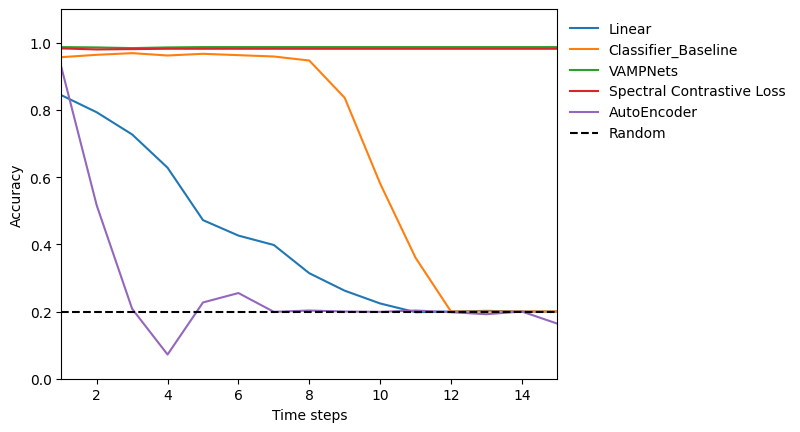

In [12]:
fig, ax = plt.subplots()
for model_name in report.keys():
    t = report[model_name]['times']
    acc = report[model_name]['accuracy']
    ax.plot(t, acc, label=model_name)

ax.axhline(1/num_digits, color='black', linestyle='--', label='Random')

ax.legend(frameon=False, bbox_to_anchor=(1, 1))
ax.margins(x=0)
ax.set_ylim(0, 1.1)
ax.set_xlabel('Time steps')
ax.set_ylabel('Accuracy')
plt.show()

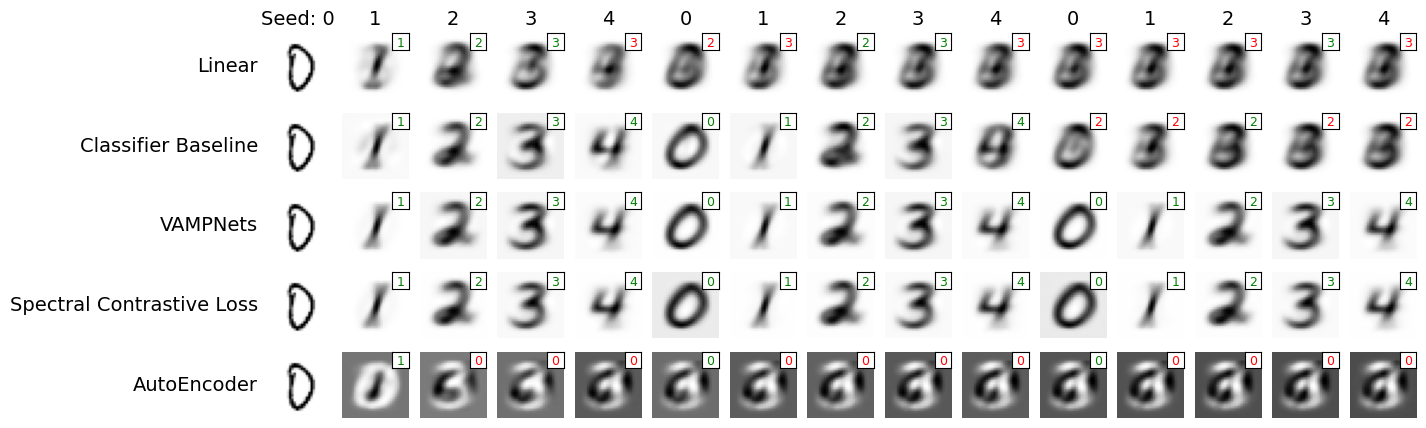

In [ ]:
nun_models = len(report)
num_cols = len(report['Linear']['times'])
fig, axes = plt.subplots(
    nun_models, num_cols, figsize=(num_cols, nun_models), sharex=True, sharey=True
    )

test_seed_idx = 0
# Remove margins between columns
plt.subplots_adjust(wspace=0)

for model_idx, model_name in enumerate(report.keys()):
    # First column
    ax = axes[model_idx, 0]
    ax.imshow(test_data[test_seed_idx], cmap='Greys')
    ax.set_axis_off()
    for prediction_step in range(num_cols - 1):
        pred_label = report[model_name]['label'][prediction_step][test_seed_idx]
        true_label = (
            test_labels[test_seed_idx] + report[model_name]['times'][prediction_step]
            )%num_digits
        img = report[model_name]['image'][prediction_step][test_seed_idx]
        logit = report[model_name]['logits'][prediction_step][test_seed_idx]

        # Set subplot for the current class
        ax = axes[model_idx, prediction_step + 1]

        # Plot the MNIST image
        ax.imshow(img, cmap='Greys')

        # Remove axes and ticks
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('off')

        # Add a white background for the subplot
        ax.set_facecolor('white')

        # Add an inset for the predicted label in the upper right corner
        if pred_label == true_label:
            color = 'green'
        else:
            color = 'red'
        inset_ax = ax.inset_axes([0.75, 0.75, 0.25, 0.25])
        inset_ax.set_xlim(0, 1)
        inset_ax.set_ylim(0, 1)
        inset_ax.text(0.5, 0.4, f"{pred_label}" , color=color, fontsize=9, ha='center', va='center')
        inset_ax.set_xticks([])
        inset_ax.set_yticks([])
        inset_ax.set_facecolor('white')

# Display the model names on the left of each row
for model_idx, model_name in enumerate(report.keys()):
    axes[model_idx, 0].text(
        -0.1,
        0.5,
        model_name.replace('_', ' '),
        fontsize=14,
        ha='right',
        va='center',
        transform=axes[model_idx, 0].transAxes
        )

for class_idx in range(num_cols):
    title = (test_labels[test_seed_idx] + class_idx)%num_digits
    if class_idx == 0:
        axes[0, class_idx].set_title(f"Seed: {title}", fontsize=14)
    else:
        axes[0, class_idx].set_title(f"{title}", fontsize=14)
plt.show()

The plots above illustrate that **encoder-only methods** outperform other approaches in predicting long-term dynamics, maintaining higher accuracy over extended forecast horizons.

### Visualization of Leading Eigenfunctions

Finally, we visualize the leading eigenfunctions corresponding to the two largest-magnitude eigenvalues of each trained evolution operator model.

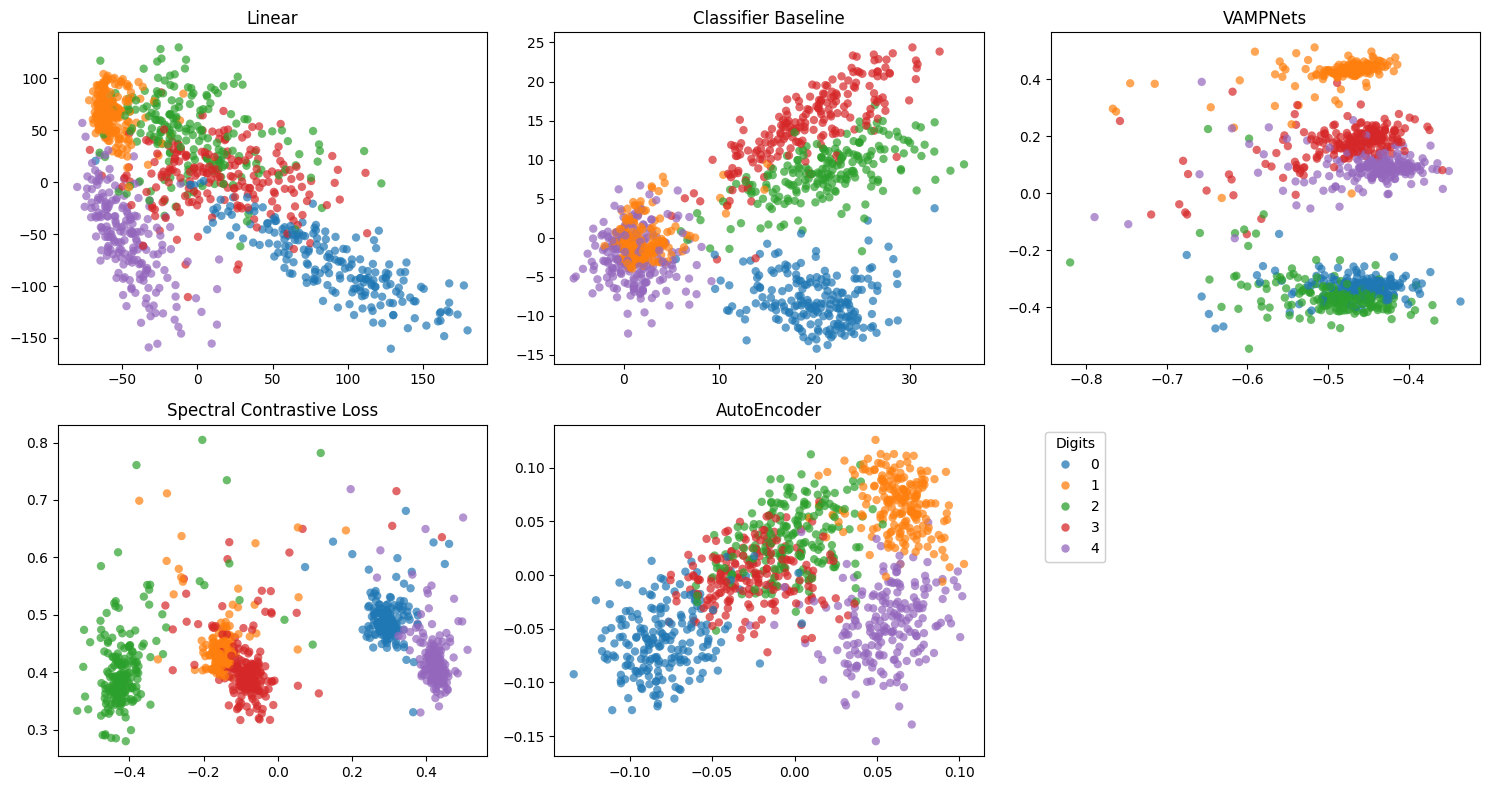

In [ ]:
from kooplearn._utils import stable_topk

n_models = len(report.keys())
num_rows, num_cols = 2, 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))
axes = axes.flatten()
for model_idx, model_name in enumerate(report.keys()):
    ax = axes[model_idx]
    ax.title.set_text(model_name.replace('_', ' '))
    fitted_model = trained_models[model_name]['model']
    embedder = trained_models[model_name]['embedder']
    vals, lfuncs, rfuncs = fitted_model.eig(
        eval_right_on=embedder.transform(test_data),
        eval_left_on=embedder.transform(test_data)
        )

    unique_vals, idx_start = np.unique(np.abs(vals), return_index=True) # returns the unique values
    # and the index of the first occurrence of a value

    vals, lfuncs, rfuncs = vals[idx_start], lfuncs[:, idx_start], rfuncs[:, idx_start]
    top_vals, top_indices = stable_topk(np.abs(vals), 2)
    idx_i = top_indices[0]
    idx_j = top_indices[1]

    fns = lfuncs
    fn_i = fns[:, idx_i].real
    fn_j = fns[:, idx_j].real

    scatter = ax.scatter(fn_i, fn_j, c=test_labels, cmap='tab10', vmax=10, alpha=0.7, linewidths=0)

# remove last axis and add legend
ax = axes[n_models-1]
legend = ax.legend(
    *scatter.legend_elements(num=4), title="Digits", frameon=True, bbox_to_anchor=(1.3, 1)
    )
ax.add_artist(legend)
fig.delaxes(axes[n_models])

plt.tight_layout()
plt.show()

The two leading eigenfunctions obtained using **encoder-only methods** form clearly separated clusters, in contrast to those from the **Linear**, **Classifier Features**, and **Autoencoder** models, which display overlapping clusters.  
Clusters separation is particularly pronounced for embeddings learned with [SpectralContrastiveLoss](../generated/kooplearn.torch.nn.SpectralContrastiveLoss.rst), highlighting that the latent space effectively disentangles the dynamics of different digits.